In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [ ]:
# Data loading, feature selection, and dataset splitting

df = pd.read_csv('sample_3000.csv')
df = df[np.isfinite(df['real_flow'])]
df = df.dropna(subset=['real_flow'])

# Feature selection
X = df.drop(columns=['real_flow', 'stationID', 'year', 'name', 'date', 'longitude', 'latitude'], errors='ignore')
y = df['real_flow']

valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# X = pd.get_dummies(X, columns=['weekday', 'hours'], drop_first=True)
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Hyperparameter tuning for XGBoost using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.2, 0.5, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',        # Fast training
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,                   # Number of random search iterations (adjustable)
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best RMSE:", (-random_search.best_score_)**0.5)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
最优参数： {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
最佳RMSE： 151.34721904732294


In [ ]:
# Model evaluation using the tuned XGBoost model

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost (tuned): MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.4f}")


XGBoost (调优后): MSE=10756.91, RMSE=103.72, MAE=54.16, R^2=0.9902


In [ ]:
import pandas as pd

# Combine test features with true and predicted values, along with error metrics
# Assumes X_test is a DataFrame, and y_test, y_pred align with X_test by index
df_result = X_test.copy()
df_result['y_true'] = y_test
df_result['y_pred'] = y_pred
df_result['error'] = y_test - y_pred        # Residuals
df_result['abs_error'] = abs(y_test - y_pred)   # Absolute error (optional)

# Save for further analysis
df_result.to_csv('X_test_with_prediction_error.csv', index=False)


In [ ]:
import shap
import pandas as pd

# Generate SHAP values and global interpretation plots for the entire dataset

# 1. Prepare the full dataset
X_all = pd.concat([X_train, X_test], axis=0)

# 2. Create SHAP explainer without specifying data
explainer = shap.TreeExplainer(best_xgb, feature_perturbation="interventional")

# 3. Compute SHAP values for the full dataset
# explanation = explainer.explanation(X_all, check_additivity=False)
explanation = explainer(X_all, check_additivity=False)

# 4. Plot global interpretation results
shap.summary_plot(explanation, X_all, max_display=X_all.shape[1])
shap.plots.bar(explanation, max_display=X_all.shape[1])


In [ ]:
import pandas as pd

# Convert SHAP Explanation object into a DataFrame and save as CSV

# 1. Assume `explanation` is the SHAP Explanation object, and X_all is the dataset used for explanation
shap_matrix = explanation.values         # (num_samples, num_features)
feature_names = X_all.columns

# 2. Convert to DataFrame and set column names
df_shap = pd.DataFrame(shap_matrix, columns=[f'SHAP_{name}' for name in feature_names])

# 3. Optional: combine original features with SHAP values for easier analysis
df_full = pd.concat([X_all.reset_index(drop=True), df_shap], axis=1)

# 4. Save to CSV
df_full.to_csv('shap_full_output_2023.csv', index=False)




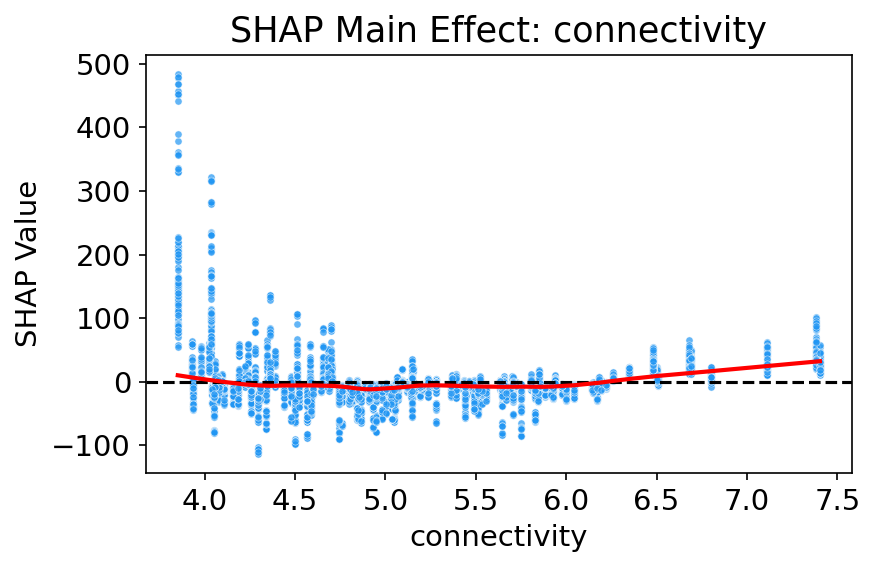

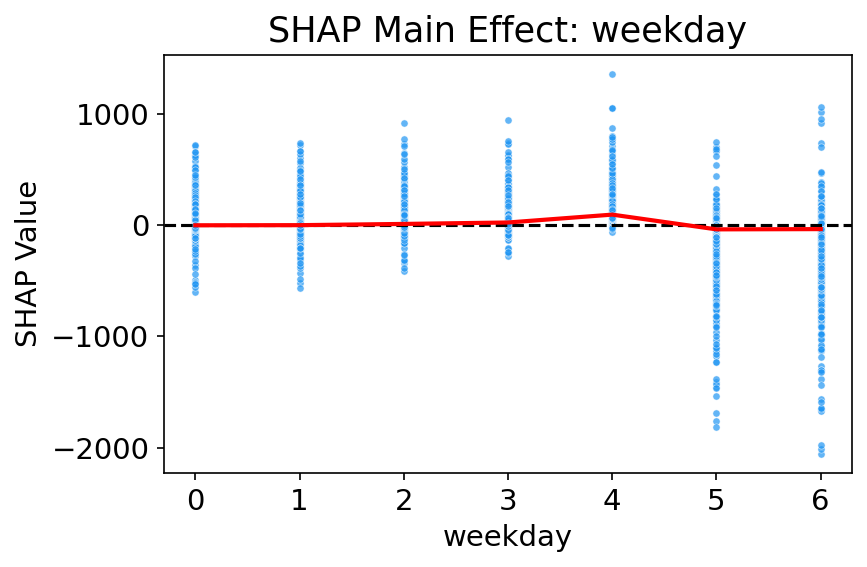

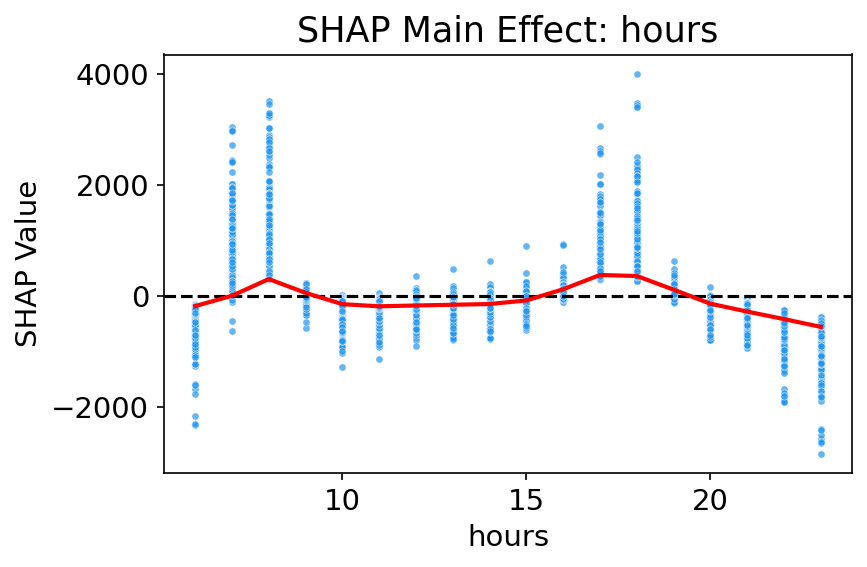

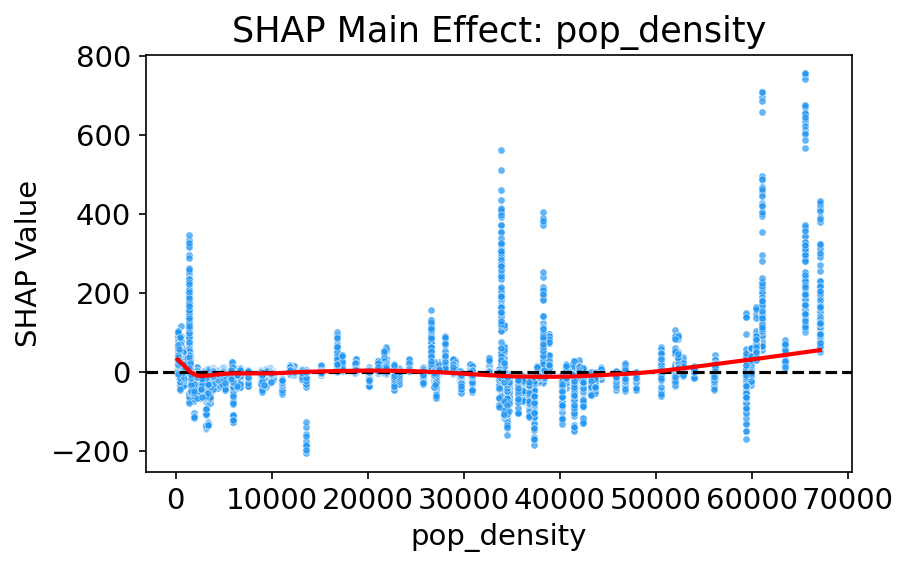

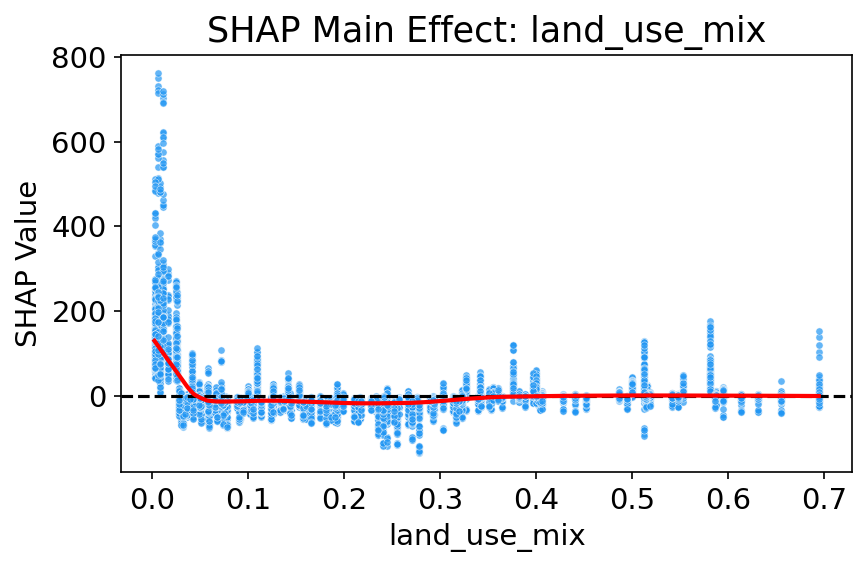

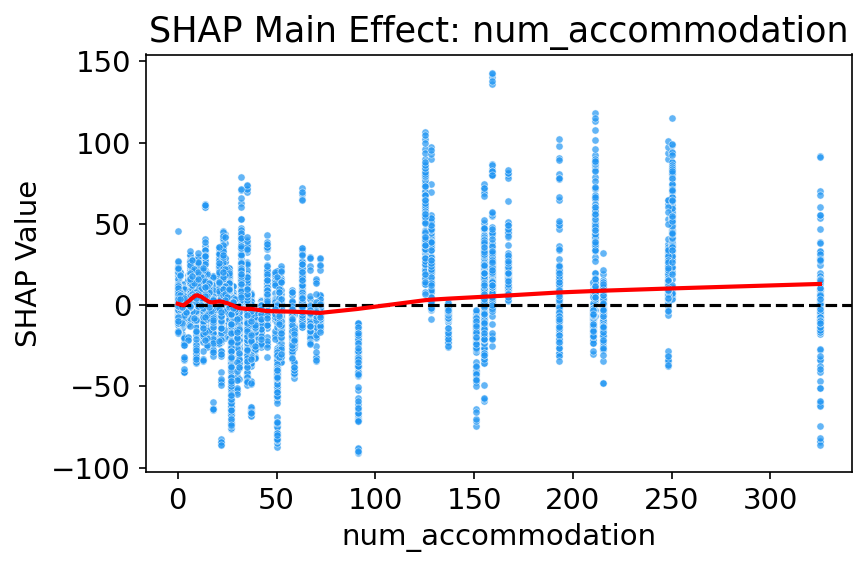

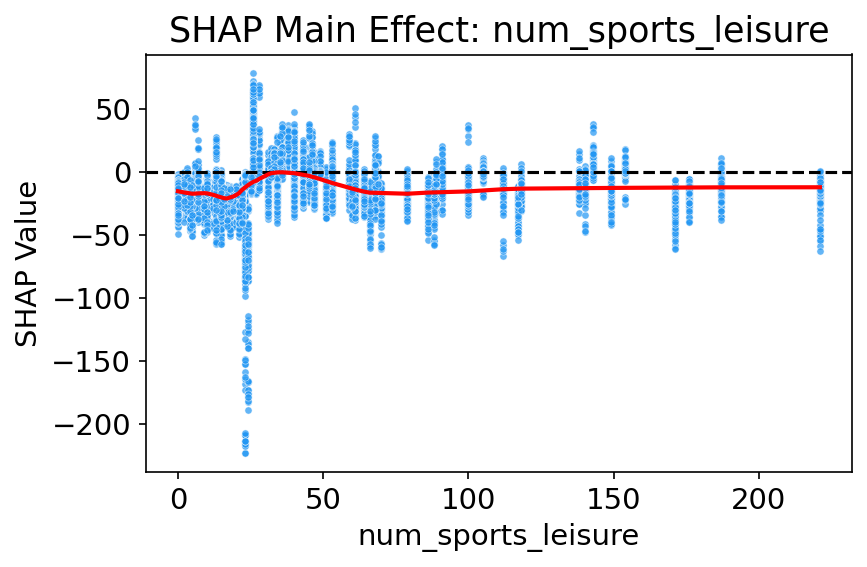

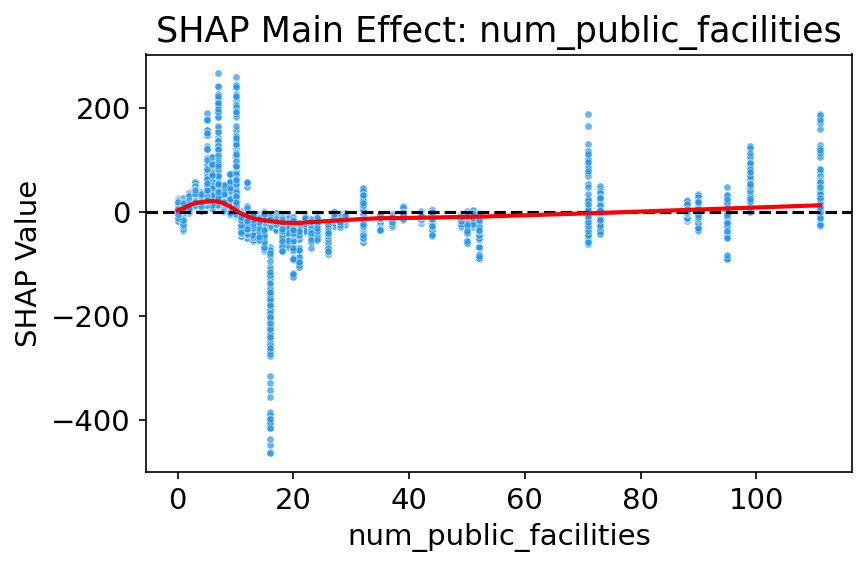

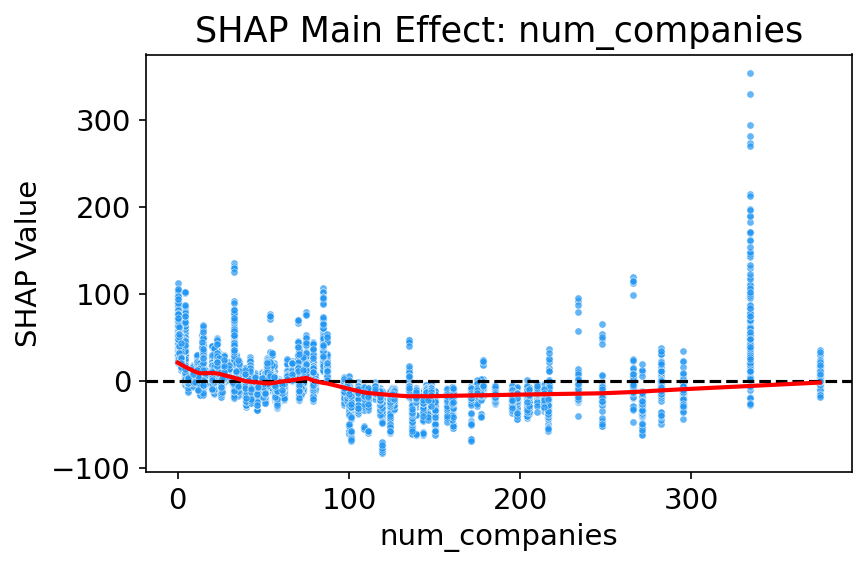

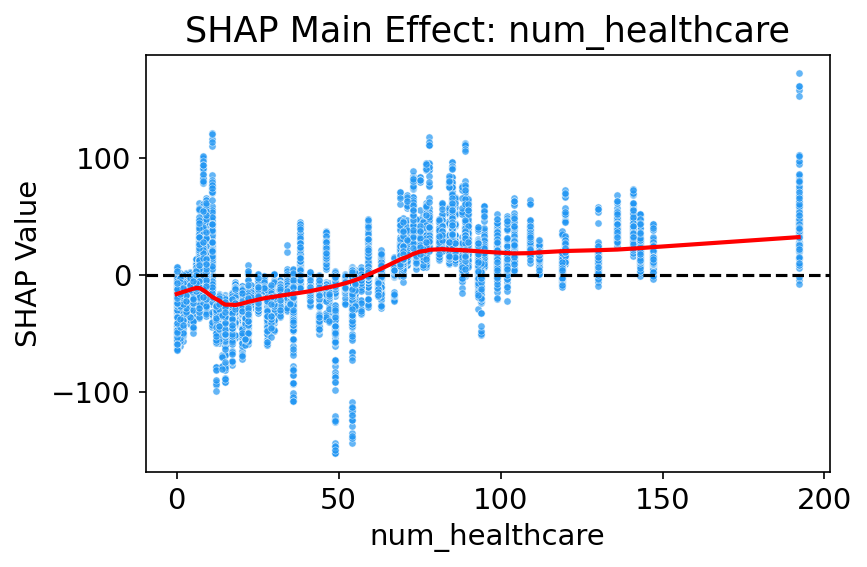

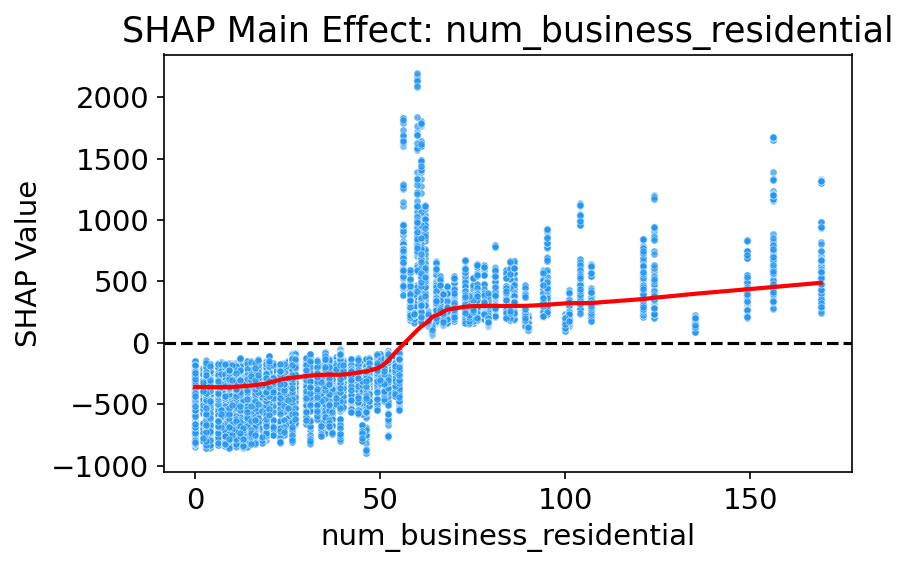

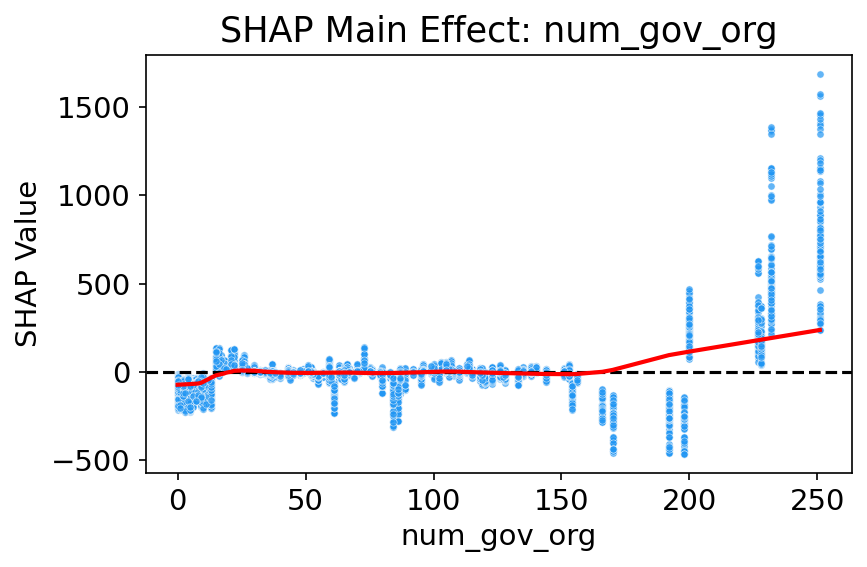

invalid value encountered in divide


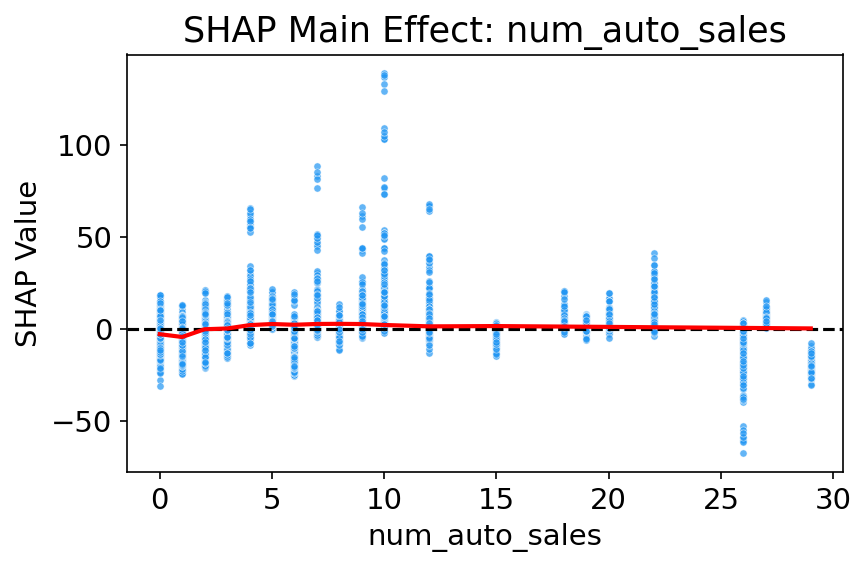

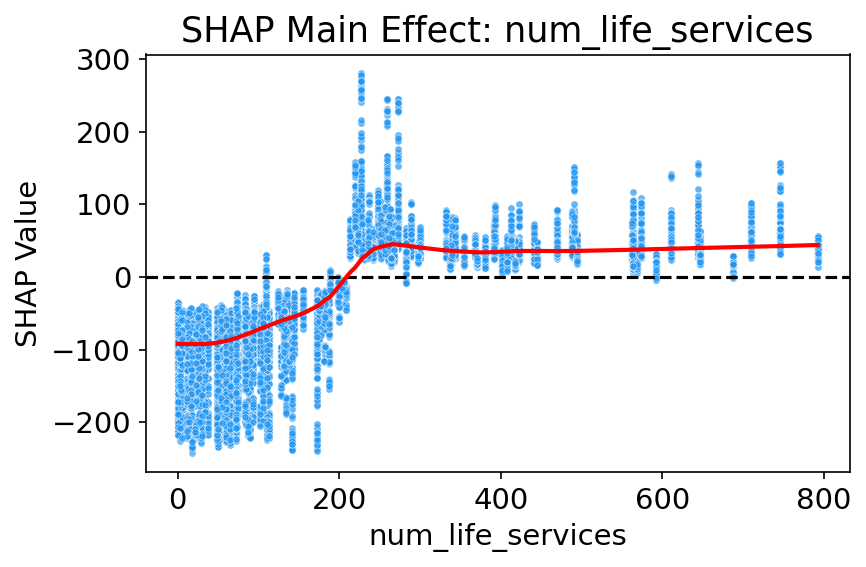

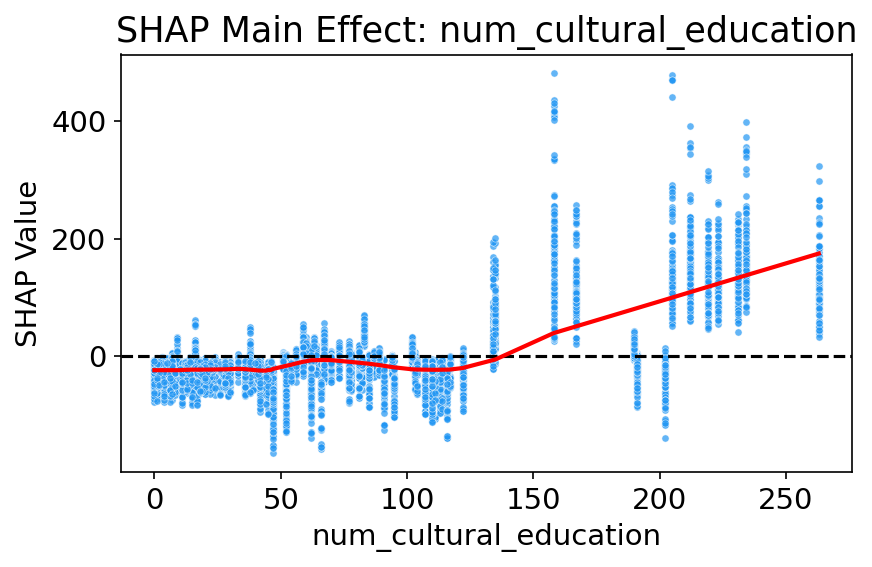

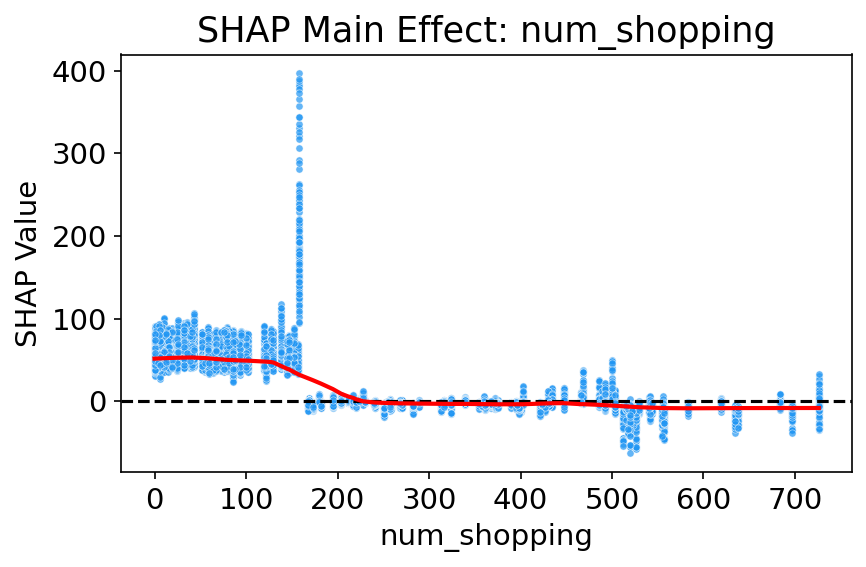

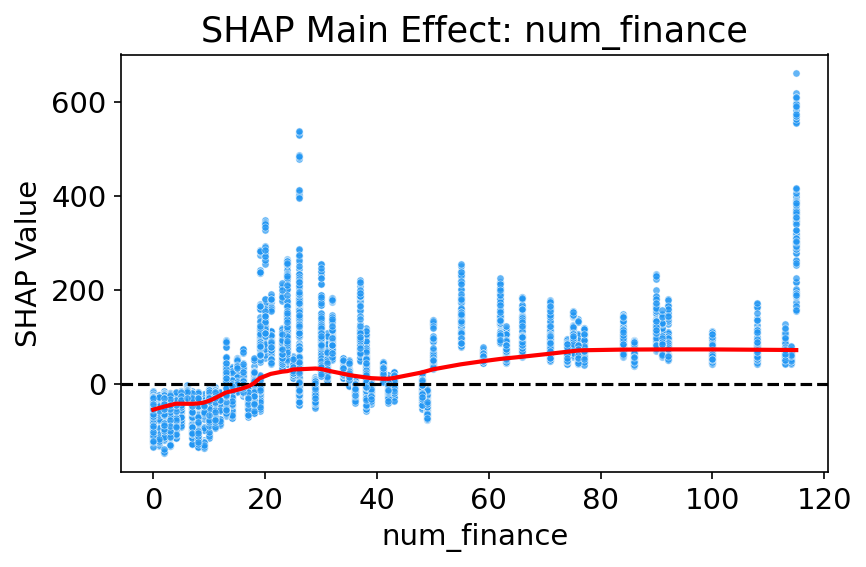

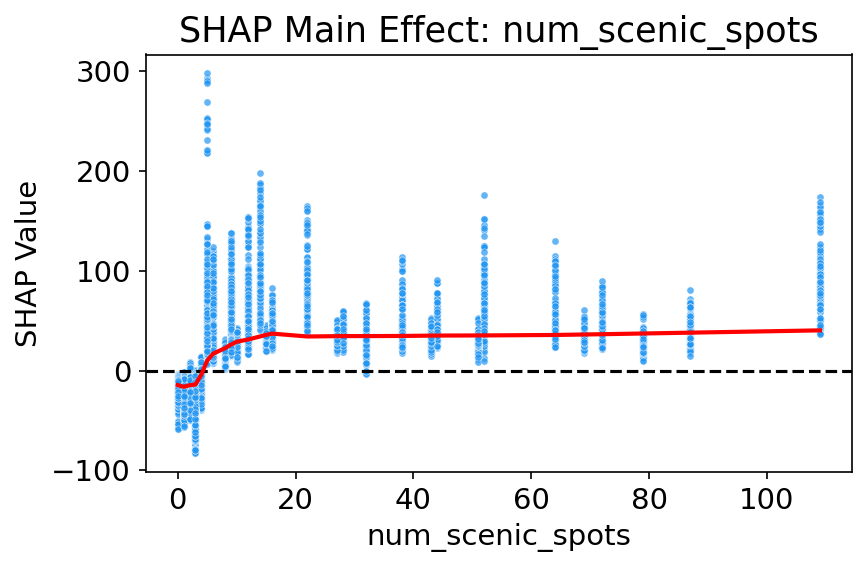

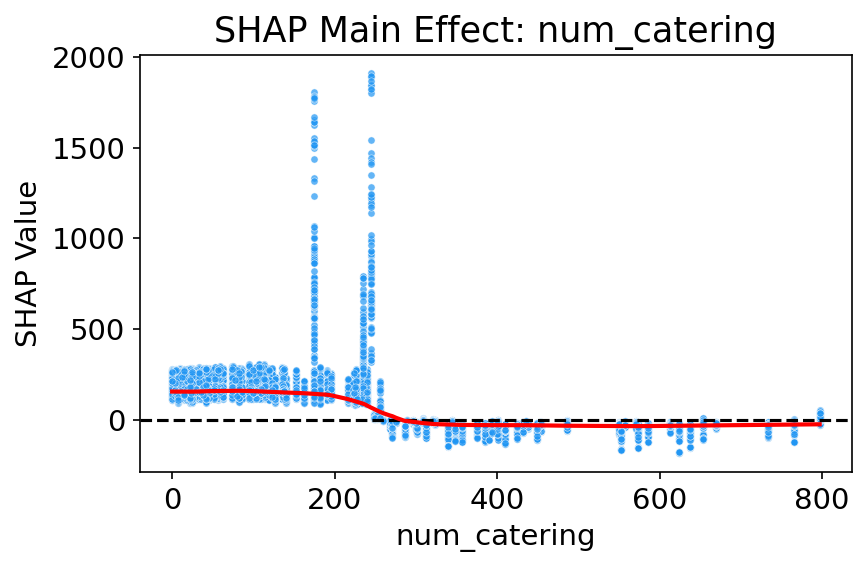

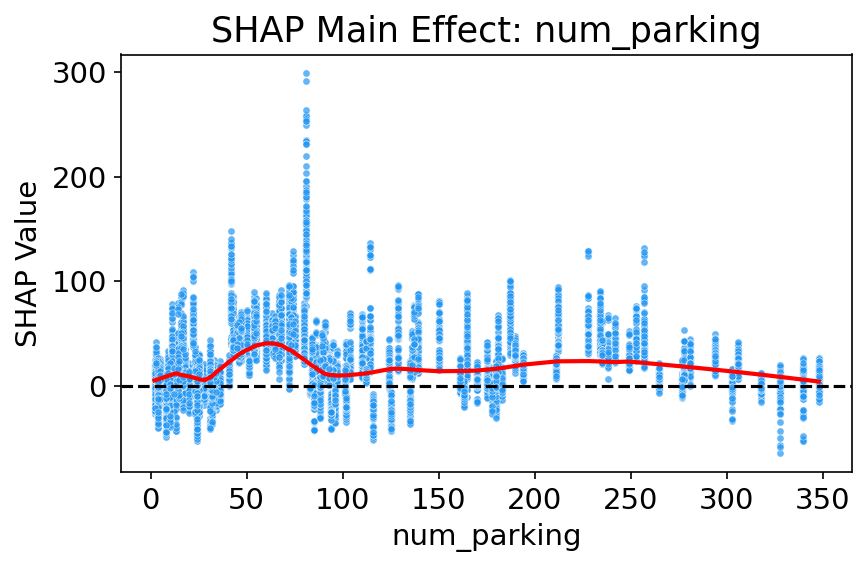

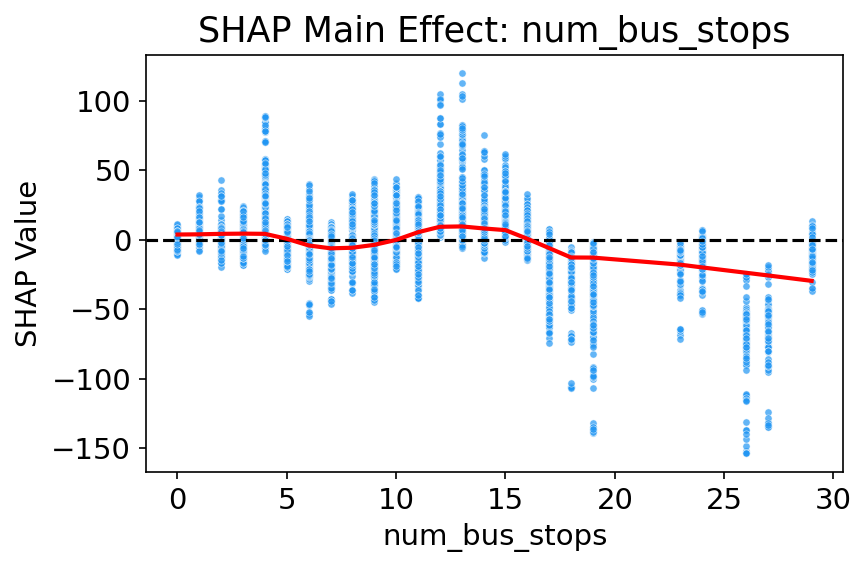

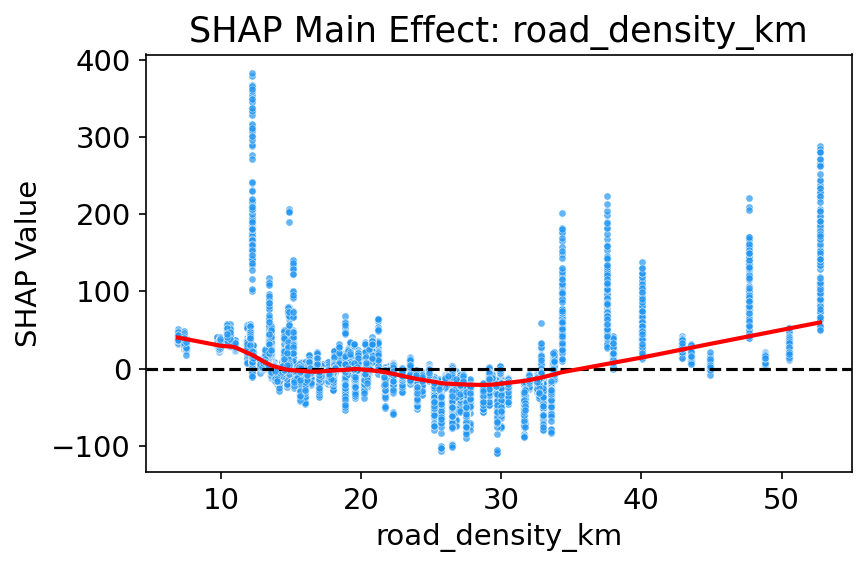

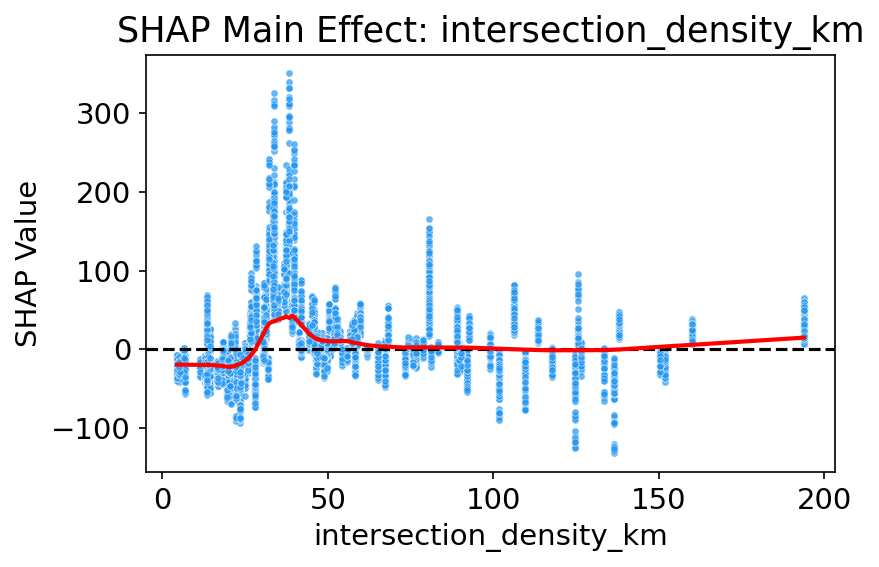

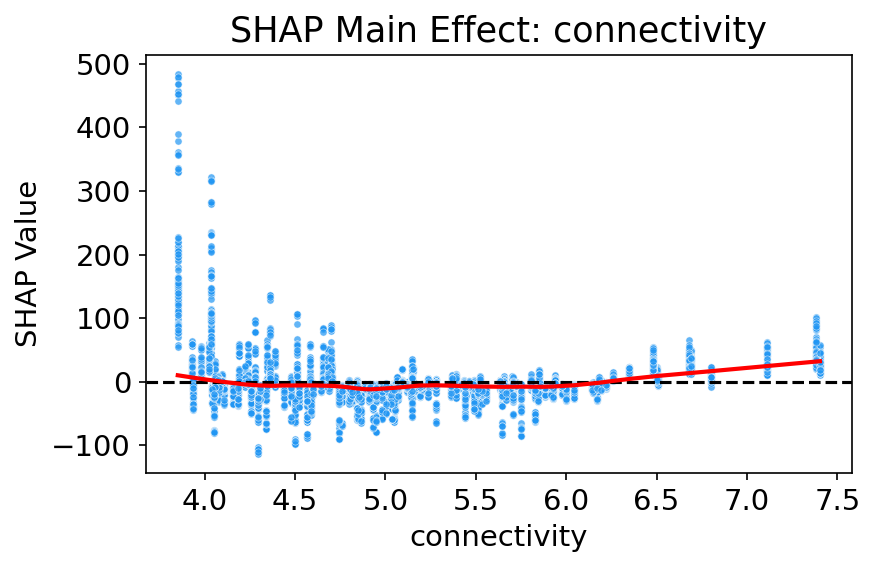

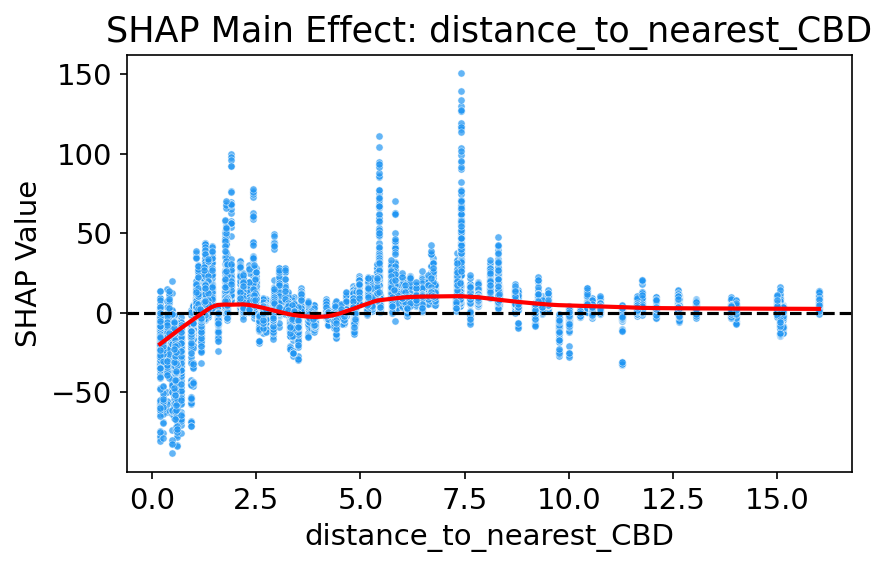

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 14

# Function to plot SHAP main effect (dependence) for a specific feature
def shap_dependence_plot(j, explanation, X, ylim=None, xlim=None, lower=0.01, upper=0.99, savefig=False):
    """
    Plot the SHAP main effect for a given feature using all samples (SHAP Explanation object).
    
    Parameters:
        j (int): Feature index.
        explanation: SHAP Explanation object.
        X (DataFrame): Dataset used for SHAP explanation (e.g., X_all), must be aligned with explanation.
        ylim (tuple, optional): Y-axis limits.
        xlim (tuple, optional): X-axis limits.
        lower (float): Lower quantile for outlier removal.
        upper (float): Upper quantile for outlier removal.
        savefig (bool): Whether to save the figure as a PNG file.
    """
    fig, ax = plt.subplots(dpi=150, figsize=(6, 4))
    x = X.iloc[:, j].values
    shap_y = explanation.values[:, j]

    # Remove outliers by keeping only data within the specified quantile range
    q_low = np.quantile(x, lower)
    q_high = np.quantile(x, upper)
    mask = (x >= q_low) & (x <= q_high)
    x = x[mask]
    shap_y = shap_y[mask]

    ax.axhline(0, linestyle='--', color='black')
    ax.scatter(x, shap_y, c="#2196F3", s=12, edgecolors="white", lw=0.3, alpha=0.7)
    smoothed = lowess(shap_y, x, frac=0.25, return_sorted=True)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color="red", lw=2)
    
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_xlabel(X.columns[j])
    ax.set_ylabel("SHAP Value")
    ax.set_title(f"SHAP Main Effect: {X.columns[j]}")
    plt.tight_layout()
    
    if savefig:
        plt.savefig(f"{X.columns[j]}_shap_main_effect_2023.png", format='png', dpi=300)
    plt.show()

# Example: plot the main effect of the feature at index 22
shap_dependence_plot(22, explanation, X_all)

# Loop through all features and save their main effect plots
for j in range(X_all.shape[1]):
    shap_dependence_plot(j, explanation, X_all, savefig=True)
